In [50]:
!pip install q keras==2.2.0
!pip install q keras-applications==1.0.2
!pip install q keras-preprocessing==1.0.1

  Using cached https://files.pythonhosted.org/packages/68/12/4cabc5c01451eb3b413d19ea151f36e33026fc0efb932bf51bcaf54acbf5/Keras-2.2.0-py2.py3-none-any.whl
  Found existing installation: Keras 2.1.6
    Uninstalling Keras-2.1.6:
      Successfully uninstalled Keras-2.1.6


In [51]:
!pip list |grep Keras

Keras                    2.2.0                
Keras-Applications       1.0.2                
Keras-Preprocessing      1.0.1                


### GPUを有効にします

メニューのRuntime -> Change Runtime typeからHardware AcceleratorでGPUを選びます。

### データセットの読み込み

データセットは https://github.com/yasudakn/umaibar/blob/master/interface-201812-umaibar-data-content.zip を利用します。

このデータセット・ファイルをPCにダウンロードしてから、次のコマンドでファイルをGoogle Colab.へアップロードします。

In [2]:
# data-content-half.zipをアップロード
from google.colab import files
uploaded = files.upload()

Saving interface-201812-3-data-content.zip to interface-201812-3-data-content.zip


データセット・ファイルを解凍します。

In [0]:
!unzip -qo interface-201812-3-data-content.zip

フォルダから画像ファイルを読み込み、正規化などの前処理を行った後にそのデータをトレイナー（学習時に利用するクラス）に渡すIteratorインスタンスを作ります。

In [52]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# 入力サイズはここで変えます。
im_rows, im_cols = (224, 224)
bs = 32
TRAIN_DIR = "data-content/train"
TEST_DIR = "data-content/test"

# featurewiseの計算の準備のため学習データのIterator
train_batchs = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    TRAIN_DIR,
    target_size = (im_rows, im_cols),
    batch_size = bs,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = "categorical"
)

x_train = np.array([])
x_train.resize((0, im_rows, im_cols, 3))
for i in range(int(train_batchs.samples/bs) + 1):
    imgs, labels = next(train_batchs)
    x_train = np.vstack((x_train, imgs))

# 学習データのGenerator
datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    horizontal_flip = True,
    vertical_flip = True,
    featurewise_center = True,
    featurewise_std_normalization = True,
    zca_whitening = False,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
#    shear_range = 0.2,
#    zoom_range = 0.2,
    rotation_range = 20,
)
datagen.fit(x_train)

# 学習データのIterator
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (im_rows, im_cols),
    batch_size = bs,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = "categorical",
)

# featurewiseの計算の準備のためテストデータのIterator
test_batchs = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    TEST_DIR,
    target_size = (im_rows, im_cols),
    batch_size = bs,
    color_mode = 'rgb',
    shuffle = False,
    class_mode = "categorical"
)

x_test = np.array([])
x_test.resize((0, im_rows, im_cols, 3))
for i in range(int(test_batchs.samples/bs) + 1):
    imgs, labels = next(test_batchs)
    x_test = np.vstack((x_test, imgs))

# テストデータのGenerator
test_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    featurewise_center = True,
    featurewise_std_normalization = True,
    zca_whitening = False
)

test_datagen.fit(x_test)

# テストデータのIterator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = (im_rows, im_cols),
    batch_size = bs,
    color_mode = 'rgb',
    shuffle = False,
    class_mode = "categorical",
)

Found 760 images belonging to 19 classes.
Found 760 images belonging to 19 classes.
Found 190 images belonging to 19 classes.
Found 190 images belonging to 19 classes.


### モデル構築

VGG16をImageNetで学習済みの重みファイルを読み込むオプションを付けて構築します。

In [0]:
from keras.applications.vgg16 import VGG16

# モデルの構築とImageNetで学習済みの重みの読み込み
base_model = VGG16(include_top=False, weights='imagenet', pooling=None)

次にFC層を追加し、ニューラルネットワークの構造を確認してみます。

In [54]:
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.models import Model

nb_classes=19

# FC層を構築
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(nb_classes, activation='softmax')(x)
model =  Model(inputs=base_model.input, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### トレーニング

#### 全結合層のプレ・トレーニング

In [7]:
# 最後のDense以外を固定する
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

model.summary()

epochs = 4
s_epochs = int(train_generator.samples / bs)

# train the model on the new data for a few epochs
# まずはDenseレイヤを学習する
model.fit_generator(train_generator, steps_per_epoch=s_epochs, epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

#### ファインチューニング

In [8]:
# 全層のうちで8割は固定し、それ以降は学習対象とする
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.8)]:
   layer.trainable = False
for layer in model.layers[int(layer_num * 0.8):]:
   layer.trainable = True

lr, decay, eps, bs = (0.001, 1e-3, 1e-8, 32)

from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=lr, decay=decay, epsilon=eps), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

トレイナーで学習を実行します。

In [9]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

epochs = 50
s_epochs = int(train_generator.samples / bs)
v_steps = int(test_generator.samples / bs)

fpath = 'umaibar_'+ base_model.name + '_weights.{epoch:03d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.h5'
cp_cb = ModelCheckpoint(filepath = fpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tb_cb = TensorBoard(log_dir="./tensorlog", histogram_freq=0)
es_cb = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=60, min_delta=0.0001)

model.fit_generator(
    train_generator, 
    steps_per_epoch=s_epochs, 
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=v_steps,
    callbacks=[cp_cb, tb_cb, es_cb]
)


Epoch 1/50
23/23 [==============================] - 16s 717ms/step - loss: 2.3578 - acc: 0.2831 - val_loss: 1.9115 - val_acc: 0.3812

Epoch 00001: val_loss improved from inf to 1.91153, saving model to umaibar_vgg16_weights.001-2.36-0.28-1.91-0.38.h5
Epoch 2/50
23/23 [==============================] - 17s 738ms/step - loss: 1.6468 - acc: 0.4656 - val_loss: 1.6608 - val_acc: 0.4810

Epoch 00002: val_loss improved from 1.91153 to 1.66080, saving model to umaibar_vgg16_weights.002-1.65-0.47-1.66-0.48.h5
Epoch 3/50
23/23 [==============================] - 13s 563ms/step - loss: 1.2505 - acc: 0.5861 - val_loss: 1.2316 - val_acc: 0.5380

Epoch 00003: val_loss improved from 1.66080 to 1.23160, saving model to umaibar_vgg16_weights.003-1.25-0.59-1.23-0.54.h5
Epoch 4/50
23/23 [==============================] - 15s 641ms/step - loss: 1.1347 - acc: 0.6404 - val_loss: 1.0587 - val_acc: 0.6329

Epoch 00004: val_loss improved from 1.23160 to 1.05870, saving model to umaibar_vgg16_weights.004-1.13-0.

### 最良の学習済みモデルの重みファイル読み込み

★上でval_lossが一番小さいモデルの重みファイルを指定すること★

In [0]:
BEST_SCORE_WEIGHTS_FILE = 'umaibar_vgg16_weights.034-0.09-0.98-0.44-0.85.h5' # WRITEME
model.load_weights(BEST_SCORE_WEIGHTS_FILE, by_name=False)

from keras.optimizers import Adam
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

### モデル評価

誤差と正答率の出力

In [56]:
score = model.evaluate_generator(test_generator, steps=6) # 1バッチごとに32枚取り出し、6回(step)繰り返すと190枚すべて取り出せる
scores = model.predict_generator(test_generator, steps=6)

print("Loss: ", score[0], "Accuracy: ", score[1])

Loss:  0.4206491106434872 Accuracy:  0.8631578972465114


グラフの軸に表示するラベル名称を定義します。

In [0]:
# 日本語を図に入れたい場合はフォントをインストールする必要があります
#target_classes = ['テリヤキバーガー', 'チーズ', 'チキンカレー', 'チョコレート', 'コンポタージュ', 'エビマヨネーズ', 
#           'レモンスカッシュ', 'めんたい', 'なっとう', 'プレミアムチーズ', 'プレミアム明太子', 'プレミアムステーキ', 
#           'シュガーラスク', 'やさいサラダ', 'サラミ', 'たこ焼き', '牛タン塩', 'とんかつソース', 'やきとり']
target_classes = ['burger', 'cheese', 'chicken_curry', 'chocolate', 'corn', 'ebimayo', 'lemon', 'mentai', 'natto',
                 'premium_cheese', 'premium_mentai', 'premium_steak', 'rusk', 'salad', 'salami', 'takoyaki', 'tongue', 'tonkatsu',
                 'yakitori']

種類ごとにConfusion Matrix(混同行列)で正解数を表示します。
また、precision(適合率), recall(再現率), f1-measure(F1スコア)を出力します。

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_preds = np.argmax(scores, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_preds)
print(cm)
print('Classification Report')

print(classification_report(test_generator.classes, y_preds, target_names=target_classes))

Confusion Matrix
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  8  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  8  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  1  0  1  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0  2  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  1  0  0  8  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  1  0  0  0  0  1  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0]
 [ 1  0  0  0  1  1  0 

Confusion Matrixを画像化します。

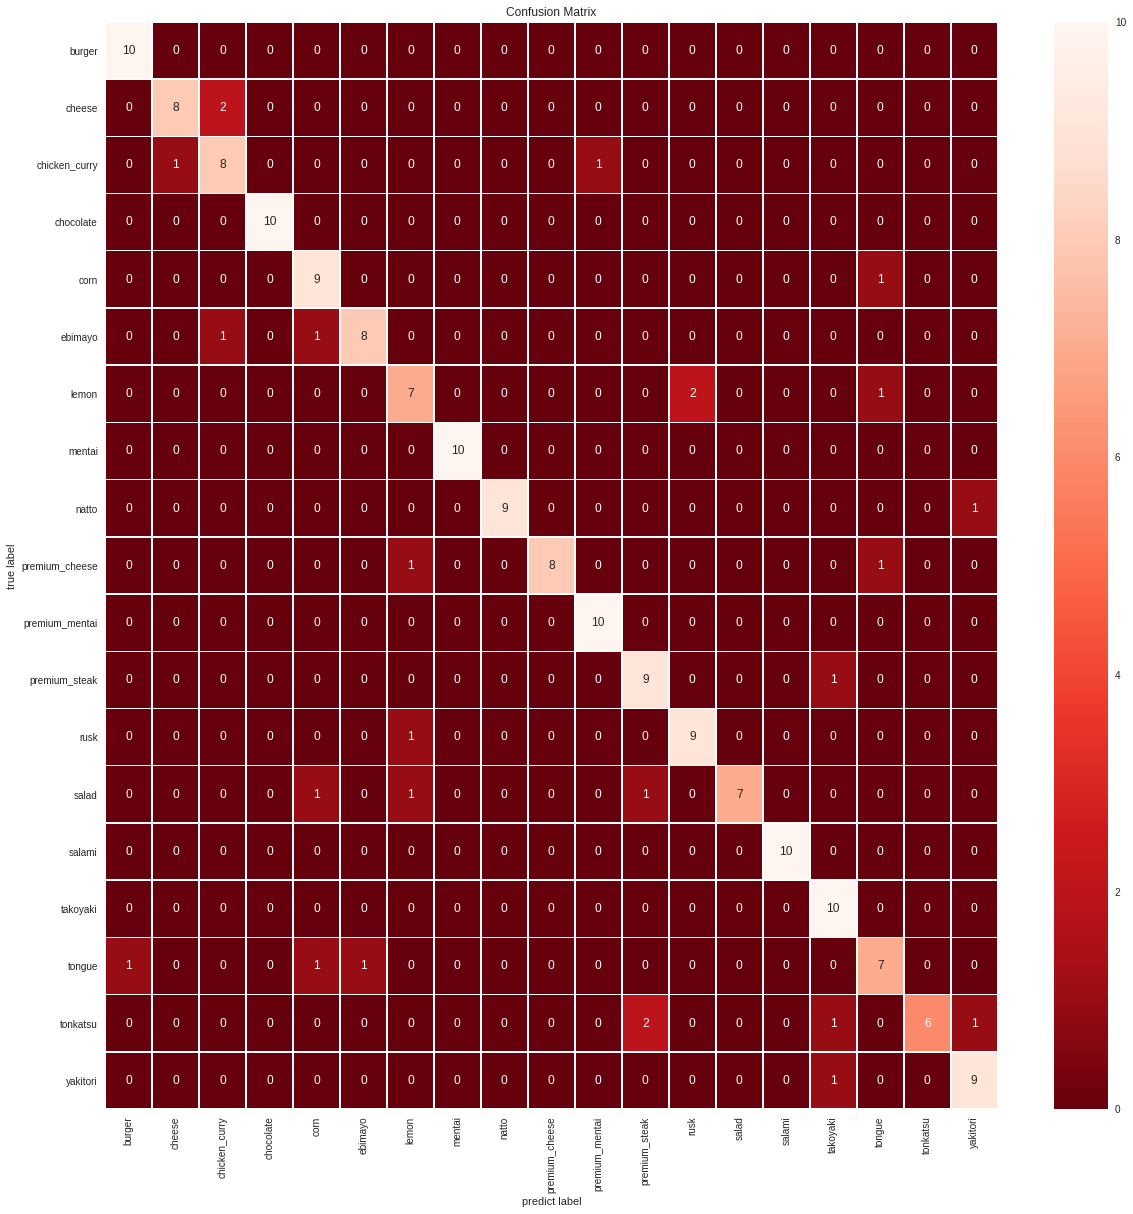

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(20,20))
ax= plt.subplot()
df = pd.DataFrame(data=cm, columns=target_classes, index=target_classes)
sns.heatmap(df, annot=True, ax = ax, linewidths=.5, fmt="d", cmap='Reds_r'); #annot=True to annotate cells

# labels, title and ticks
#ax.set_xlabel('予測結果')
#ax.set_ylabel('正解ラベル')
ax.set_xlabel('predict label')
ax.set_ylabel('true label')
ax.set_title('Confusion Matrix')
plt.show()

テストデータに対する各種類の確信度(確率)をCSVファイルに書き込みます。

In [0]:
import csv

with open('umaibo_predict' + base_model.name + '.csv', 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(['filename'] + target_classes)

    for i, file in enumerate(test_generator.filenames):
        if i < len(scores):
            writer.writerow([file]+[str(x) for x in scores[i]])


In [60]:
import pandas as pd

df = pd.read_csv('umaibo_predict' + base_model.name + '.csv', names=target_classes)
df

,burger,cheese,chicken_curry,chocolate,corn,ebimayo,lemon,mentai,natto,premium_cheese,premium_mentai,premium_steak,rusk,salad,salami,takoyaki,tongue,tonkatsu,yakitori
filename,burger,cheese,chicken_curry,chocolate,corn,ebimayo,lemon,mentai,natto,premium_cheese,premium_mentai,premium_steak,rusk,salad,salami,takoyaki,tongue,tonkatsu,yakitori
burger/IMG_20180718_185022_half.jpg,0.99221885,1.1066106e-08,0.00033339273,3.542586e-08,3.7339987e-10,3.6998176e-06,1.9020207e-07,4.802361e-08,0.00016574119,2.669339e-05,4.229009e-08,0.0032802946,2.3666018e-07,3.7657892e-07,3.3612132e-06,2.8012753e-06,3.3599434e-08,0.0035472536,0.00041704605
burger/IMG_20180718_185110_half.jpg,0.6955113,1.2257975e-08,8.266475e-05,1.322974e-07,2.331079e-09,3.122398e-05,2.3732921e-08,1.8249096e-06,0.0016528309,5.691012e-06,8.419519e-06,0.23741181,1.6867018e-08,2.7465953e-06,3.5879162e-05,0.0019421368,7.141649e-08,0.05388133,0.009431905
burger/IMG_20180718_185231_half.jpg,0.9865261,3.2120275e-07,0.00062578754,6.12973e-06,1.9099215e-07,0.00031547822,8.143133e-06,3.9065978e-07,0.0037789592,0.00018665193,4.1597892e-07,0.0043375427,2.0324678e-06,4.7161343e-06,0.00040843635,6.197504e-06,4.829383e-06,0.0029358491,0.00085179816
burger/P1040719_half.JPG,0.993266,1.976774e-11,2.863018e-07,1.5402254e-09,2.9989618e-14,1.4152424e-05,2.2206865e-11,3.2683453e-10,5.6769372e-06,9.026783e-08,1.9144865e-11,3.1372547e-05,2.5587456e-11,4.617071e-09,1.4201798e-07,1.6087975e-07,9.308008e-13,0.0066641173,1.8089231e-05
burger/P1040732_half.JPG,0.96342015,9.440431e-10,4.6423138e-05,2.400621e-06,1.1724365e-12,0.019600796,7.729566e-09,1.5070386e-08,0.01578158,2.4235127e-05,6.509624e-11,6.862727e-05,4.807567e-10,6.261338e-07,1.0090633e-06,1.7834576e-08,9.447298e-09,0.0010520632,1.9939387e-06
burger/P1040733_half.JPG,0.9992094,6.907837e-10,1.620041e-05,1.4200381e-06,7.513712e-12,3.145468e-05,3.7044183e-09,2.728205e-07,0.0005613578,3.1472878e-06,8.2304513e-10,3.950559e-06,1.10837096e-10,4.426043e-05,4.0696314e-06,5.8045725e-07,2.0058621e-08,3.2339714e-05,9.150678e-05
burger/P1040740_half.JPG,0.999835,6.433231e-13,1.6633777e-09,6.935348e-11,2.7902808e-13,3.5231394e-06,3.5532712e-12,2.0160611e-12,3.9078222e-05,2.953601e-07,7.894968e-12,3.460343e-05,1.2568843e-13,5.2115143e-07,2.292004e-06,3.6162493e-08,7.803816e-10,6.983169e-05,1.4700778e-05
burger/P1040745_half.JPG,0.9787991,3.519345e-10,3.181608e-06,9.6271275e-09,1.7717223e-13,0.00083929725,7.0832445e-10,2.4663163e-07,0.00058422517,1.1626329e-06,3.2272235e-10,1.1323e-05,4.4704232e-10,1.30235485e-05,1.4921805e-07,1.7217253e-07,9.472415e-09,0.013441915,0.006306257
burger/P1040751_half.JPG,0.9999614,5.521639e-23,1.0007245e-15,5.9183696e-14,3.91826e-19,9.019326e-10,8.456918e-18,7.3715707e-22,6.3717005e-09,3.9686333e-14,9.2086794e-21,3.13223e-09,2.226138e-25,2.477882e-10,3.862267e-05,1.5259634e-15,2.4683634e-17,1.5231612e-10,1.7622638e-17


### 注目領域の可視化

参考にしたコード

* Grad-CAM, Guided Grad-CAM https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py

#### Grad-CAM

In [0]:
import keras.backend as K
import cv2

def grad_cam(model, image, x, layer_name):
    # predict target image
    predictions = model.predict(x, batch_size=1, verbose=0)
    class_idx = np.argmax(predictions[0])
    loss = model.output[:, class_idx]

    conv_output = model.get_layer(layer_name).output
    
    grads = K.gradients(loss, conv_output)[0]
    gradient_function = K.function([model.input], [conv_output, grads])

    # get gradients
    output, grads_val = gradient_function([x])
    output, grads_val = output[0], grads_val[0]

    # mean and dot
    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.dot(output, weights)

    # create heatmap
    cam = cv2.resize(cam, (im_rows, im_cols), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    heatmap = cam / cam.max()

    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # coloring
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)  # to RGB
    cam = (np.float32(cam) + image) # composite original image
    
    return cam, heatmap, class_idx


ある1枚の画像に対する可視化結果を確認してみます。

In [0]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

TEST_IMG = 'data-content/test/burger/IMG_20180718_185022_half.jpg'
image = img_to_array(load_img(TEST_IMG, target_size=(im_rows, im_cols)))
image = np.expand_dims(image, axis=0)
x = test_datagen.flow(image, batch_size=1, shuffle=False)

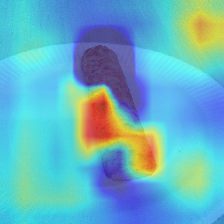

In [63]:
cam, heatmap, predictions = grad_cam(model, image, x.next(), "block5_conv3")
array_to_img(cam[0])

#### Guided Grad-CAM

In [0]:
from tensorflow.python.framework import ops
import keras
import tensorflow as tf

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        base_model = VGG16(include_top=False, weights='imagenet', pooling=None)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        predictions = Dense(nb_classes, activation='softmax')(x)
        new_model =  Model(inputs=base_model.input, outputs=predictions)
        
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [0]:
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')

guided_model.load_weights(BEST_SCORE_WEIGHTS_FILE, by_name=False)

guided_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

saliency_fn = compile_saliency_function(guided_model, activation_layer='block5_conv3')

def saliency_process(x):
    return saliency_fn([x])

同じようにある1枚の画像で可視化結果を確認してみます。

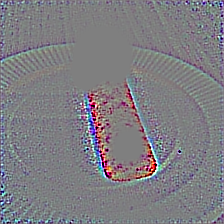

In [0]:
saliency = saliency_process(x.next())
guided = saliency[0] * heatmap[..., np.newaxis]
array_to_img(deprocess_image(guided))

In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.preprocessing.image import array_to_img, img_to_array

def walk_grad_cam(target_dir, pred_generator, layer_name):
    images = []
    guided_images = []
    for dirpath, dirnames, filenames in os.walk(target_dir):
        for file in sorted(filenames):
            image = img_to_array(load_img(os.path.join(dirpath, file), target_size=(im_rows, im_cols)))
            x = pred_generator.next()[0]  # ImageDataGeneratorの前処理を行いたいため
            cam, heatmap, class_idx = grad_cam(model, image, x, layer_name)
            cam_image = array_to_img(cam)
            cam_image.save(os.path.join(dirpath, os.path.splitext(file)[0] + '_gradcam.jpg'), 'JPEG', quality=100, optimize=True)
            
            saliency = saliency_process(x)
            gradcam = saliency[0] * heatmap[..., np.newaxis]
            guided_cam_image = array_to_img(deprocess_image(gradcam))
            guided_cam_image.save(os.path.join(dirpath, os.path.splitext(file)[0] + '_guided.jpg'), 'JPEG', quality=100, optimize=True)

            images.append([class_idx, cam_image, guided_cam_image])

    # 同じフォルダに保存します。次のテスト前に削除する必要があります。
    (d, filename) = os.path.split(target_dir)
    result_images = 'gradcam_'+ filename + '.jpg'
    # 生成した画像を3x3で描画
    fig = plt.figure()
    gs = gridspec.GridSpec(3, 3)
    gs.update(wspace=0.1, hspace=0.3)
    for i in range(9):
        img = images[i][1]
        plt.subplot(gs[i])
        plt.imshow(img, aspect='auto')
        plt.title(target_classes[images[i][0]])
        plt.axis("off")
    plt.savefig(result_images)
    plt.close(fig)

    result_images = 'guided_'+ filename + '.jpg'
    # 生成した画像を3x3で描画
    fig = plt.figure()
    gs = gridspec.GridSpec(3, 3)
    gs.update(wspace=0.1, hspace=0.3)
    for i in range(9):
        img = images[i][2]
        plt.subplot(gs[i])
        plt.imshow(img, aspect='auto')
        plt.title(target_classes[images[i][0]])
        plt.axis("off")
    plt.savefig(result_images)
    plt.close(fig)


#### 全テストデータでGrad-CAMおよびGuidedを実行

In [0]:
pred_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(im_rows, im_cols),
    batch_size=1,
    color_mode='rgb',
    shuffle=False,
    class_mode="categorical"
)
test_generator.reset()

# DirectoryIterator, sortedは文字列順でソートする。
for dirpath, dirnames, filenames in os.walk(TEST_DIR):
    for dirname in sorted(dirnames):
        walk_grad_cam(os.path.join(dirpath, dirname), pred_generator, 'block5_conv3')

Found 190 images belonging to 19 classes.


#### CAM画像を保存

In [0]:
!find data-content -name \*_guided.jpg -print | xargs tar jcf guided-data-content.tar.bz2
!find data-content -name \*_gradcam.jpg -print | xargs tar jcf gradcam-data-content.tar.bz2

#### 同じフォルダに作られたCAM画像を削除

In [0]:
!find data-content -name \*_guided.jpg -print | xargs rm -f
!find data-content -name \*_gradcam.jpg -print | xargs rm -f

出来上がった 9 on 1の画像を表示させて見てみます。

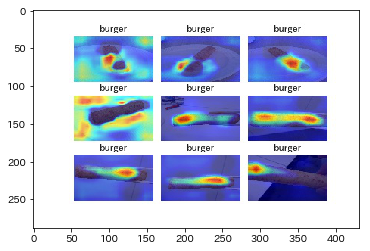

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
im = Image.open('gradcam_burger.jpg', 'r')
plt.imshow(np.array(im))

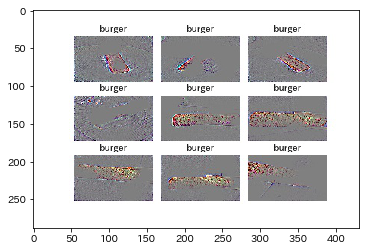

In [0]:
im = Image.open('guided_burger.jpg', 'r')
plt.imshow(np.array(im))